# Heart Disease ML Portfolio Project
This notebook implements K-means clustering, PCA, and supervised learning on the Heart Disease UCI dataset (Cleveland subset).

## Data Preprocessing
Cleaning, encoding, scaling, and feature engineering for the Cleveland dataset.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import Scikit modules
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
df = pd.read_csv('../data/heart_disease_uci.csv')

# Filter to Cleveland data
df_cleveland = df[df['dataset'] == 'Cleveland'].copy()
print("Cleveland Shape:", df_cleveland.shape)

Cleveland Shape: (304, 16)


In [2]:
# Check missing values
print("Missing Values:\n", df_cleveland.isnull().sum())

# Impute numerical columns with median
df_cleveland['trestbps'] = df_cleveland['trestbps'].fillna(df_cleveland['trestbps'].median())
df_cleveland['chol'] = df_cleveland['chol'].fillna(df_cleveland['chol'].median())
df_cleveland['thalch'] = df_cleveland['thalch'].fillna(df_cleveland['thalch'].median())
df_cleveland['oldpeak'] = df_cleveland['oldpeak'].fillna(df_cleveland['oldpeak'].median())
df_cleveland['ca'] = df_cleveland['ca'].fillna(df_cleveland['ca'].median())

# Convert boolean-like columns to string to avoid warning
df_cleveland['fbs'] = df_cleveland['fbs'].astype(str)
df_cleveland['exang'] = df_cleveland['exang'].astype(str)

# Impute categorical columns with mode
df_cleveland['fbs'] = df_cleveland['fbs'].fillna(df_cleveland['fbs'].mode()[0])
df_cleveland['restecg'] = df_cleveland['restecg'].fillna(df_cleveland['restecg'].mode()[0])
df_cleveland['exang'] = df_cleveland['exang'].fillna(df_cleveland['exang'].mode()[0])
df_cleveland['slope'] = df_cleveland['slope'].fillna(df_cleveland['slope'].mode()[0])
df_cleveland['thal'] = df_cleveland['thal'].fillna(df_cleveland['thal'].mode()[0])

# Verify no missing values
print("\nMissing Values After Imputation:\n", df_cleveland.isnull().sum())

Missing Values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       1
ca          5
thal        3
num         0
dtype: int64

Missing Values After Imputation:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


### Encoding Categorical Variables
Converting categorical columns to numerical format for ML models.

In [3]:
# Label encode binary/categorical columns
le = LabelEncoder()
df_cleveland['sex'] = le.fit_transform(df_cleveland['sex'])
df_cleveland['fbs'] = le.fit_transform(df_cleveland['fbs'])
df_cleveland['exang'] = le.fit_transform(df_cleveland['exang'])

# One-hot encode multi-class categorical columns
df_cleveland = pd.get_dummies(df_cleveland, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

# Binarize target (num: 0 vs 1-4)
df_cleveland['target'] = df_cleveland['num'].apply(lambda x: 0 if x == 0 else 1)
print("\nTarget Distribution:\n", df_cleveland['target'].value_counts())


Target Distribution:
 target
0    165
1    139
Name: count, dtype: int64


### Scaling Numerical Features
Standardizing numerical features for K-means and PCA.

In [4]:
# Select numerical features
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
scaler = StandardScaler()
df_cleveland[numerical_cols] = scaler.fit_transform(df_cleveland[numerical_cols])

print("\nScaled Features Sample:\n", df_cleveland[numerical_cols].head())


Scaled Features Sample:
         age  trestbps      chol    thalch   oldpeak        ca
0  0.946671  0.759079 -0.255962  0.012072  1.090644 -0.709371
1  1.384538  1.614169  0.762828 -1.822829  0.400262  2.509268
2  1.384538 -0.666070 -0.332852 -0.905379  1.349537  1.436388
3 -1.899464 -0.096010  0.070820  1.628532  2.126216 -0.709371
4 -1.461597 -0.096010 -0.813413  0.973210  0.313965 -0.709371


### Feature Engineering
Creating new features to enhance model performance.

In [5]:
# Create interaction term: age * chol
df_cleveland['age_chol'] = df_cleveland['age'] * df_cleveland['chol']

# Create binary feature: high_risk_bp (trestbps > 140, scaled)
df_cleveland['high_risk_bp'] = (df_cleveland['trestbps'] > scaler.mean_[numerical_cols.index('trestbps')]).astype(int)

print("\nNew Features Sample:\n", df_cleveland[['age_chol', 'high_risk_bp']].head())


New Features Sample:
    age_chol  high_risk_bp
0 -0.242312             0
1  1.056164             0
2 -0.460846             0
3 -0.134519             0
4  1.188882             0


### Data Cleanup
Dropping non-relevant columns to streamline the DataFrame.

In [11]:
# Drop non-relevant columns
df_cleveland = df_cleveland.drop(columns=['id', 'dataset', 'num'], errors='ignore')
print("Updated Columns:\n", df_cleveland.columns.tolist())
print("\nColumn Data Types:\n", df_cleveland.dtypes)

Updated Columns:
 ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'target', 'age_chol', 'high_risk_bp']

Column Data Types:
 age                         float64
sex                           int64
trestbps                    float64
chol                        float64
fbs                           int64
thalch                      float64
exang                         int64
oldpeak                     float64
ca                          float64
cp_atypical angina             bool
cp_non-anginal                 bool
cp_typical angina              bool
restecg_normal                 bool
restecg_st-t abnormality       bool
slope_flat                     bool
slope_upsloping                bool
thal_normal                    bool
thal_reversable defect         bool
target          

### Initial Visualizations
Exploring data relationships and distributions.

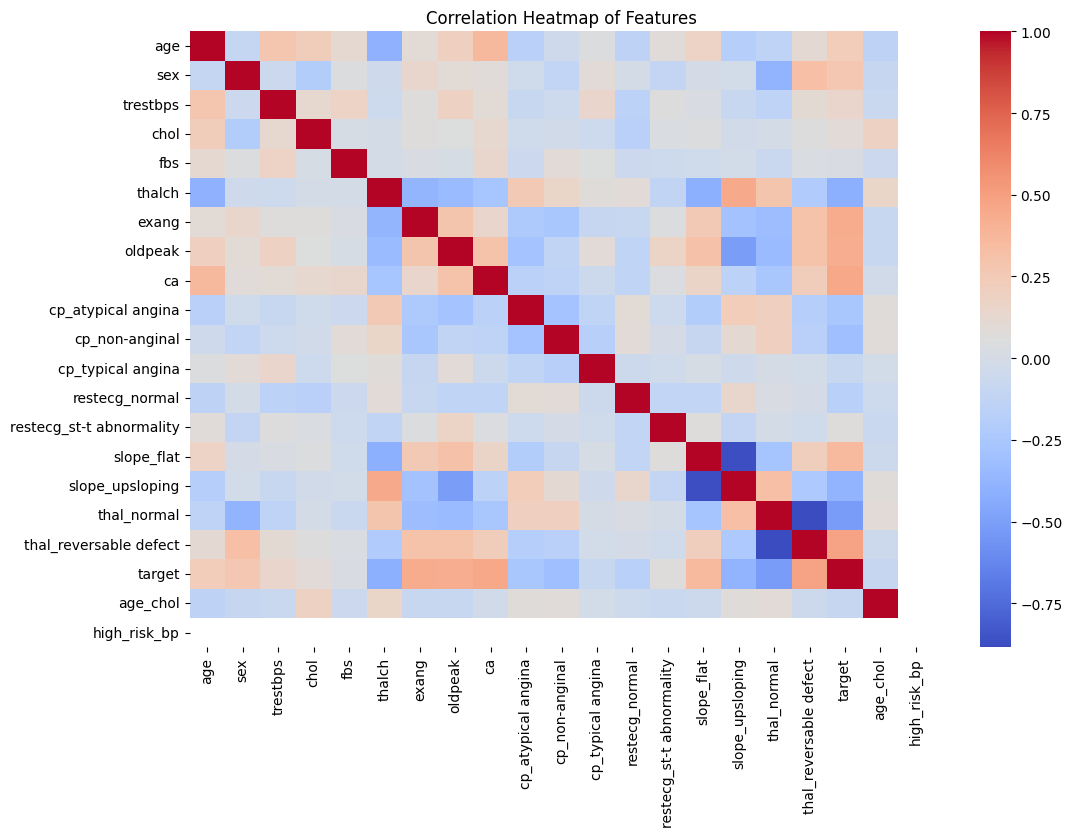

In [12]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleveland.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.savefig('../images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

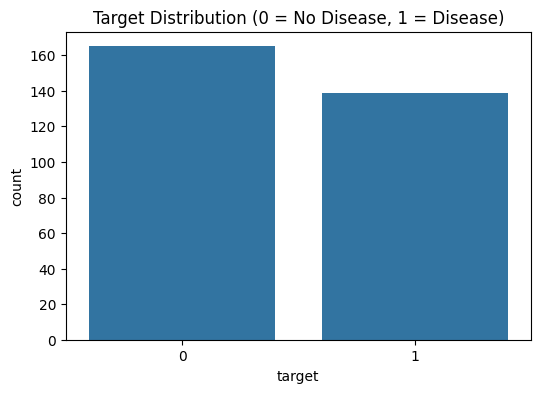

In [7]:
# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_cleveland)
plt.title('Target Distribution (0 = No Disease, 1 = Disease)')
plt.savefig('../images/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

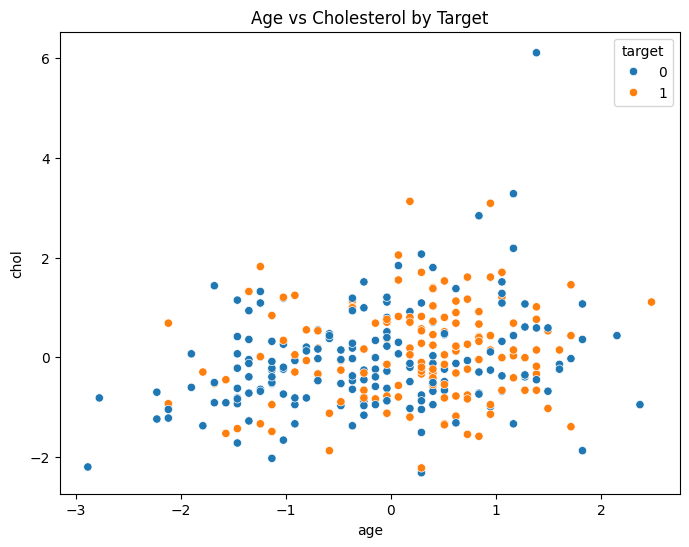

In [8]:
# Age vs Cholesterol scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='chol', hue='target', data=df_cleveland)
plt.title('Age vs Cholesterol by Target')
plt.savefig('../images/age_chol_scatter.png', dpi=300, bbox_inches='tight')
plt.show()